## Get API key

In [32]:
import os
import getpass

# Set the environment variable
os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API key: ")

In [ ]:
# nt9wg84wNjGfVEwC9ysQuAVdEJlT9bDYjtMeMA8g

In [33]:
cohere_api_key = os.environ["COHERE_API_KEY"]
print(cohere_api_key)

nt9wg84wNjGfVEwC9ysQuAVdEJlT9bDYjtMeMA8g


## load Cohere model 

In [ ]:
from langchain_cohere.llms import Cohere

# model = Cohere(temperature=0.1)
model = Cohere(cohere_api_key=cohere_api_key, model="command", temperature=0.1)

In [34]:
from langchain_cohere import ChatCohere

chat_model = ChatCohere(cohere_api_key=cohere_api_key, model="command-r-plus", temperature=0.1)

## Memory

In [35]:
from langchain_community.chat_message_histories import ChatMessageHistory

history = ChatMessageHistory()
history.add_user_message("این جمله رو به فرانسوی ترجمه کن: من عاشق برنامه‌نویسی‌ام")
history.add_ai_message("J'adore la programmation.")

print(history.messages)

[HumanMessage(content='این جمله رو به فرانسوی ترجمه کن: من عاشق برنامه\u200cنویسی\u200cام', additional_kwargs={}, response_metadata={}), AIMessage(content="J'adore la programmation.", additional_kwargs={}, response_metadata={})]


## Chat with Memory

In [11]:
import time
history = ChatMessageHistory()

while(True):
    input_ = input("سوالت را بگو. اگر میخواهی چت متوقف شود، عدد 0 را وارد کن")
    
    if input_ != "0":
        history.add_user_message(input_)
        print(f"Human: {input_}")

        output = ""
        print("AI: ", end="")
        for chunk in chat_model.stream(history.messages):
            output = output + chunk.content
            print(chunk.content, end="", flush=True)
            time.sleep(0.1)
        print()

        history.add_ai_message(output)
    else:
        print("Chat is done!!!")
        break

Human: hi
AI: Hello! How can I help you today?
Human: what is brother in persian?
AI: 'Brother' in Persian is 'برادر' (baráadar).
Human: and sister?
AI: 'Sister' in Persian is 'خواهر' (khahaar).
Human: what was the first word in our chat?
AI: The first word in our chat was 'hi'.
Chat is done!!!


## Automatation history

In [36]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "تو یک مدل گفت‌وگو هستی که مانند دوست با کاربر صحبت می‌کنی."),
        ("placeholder", "{chat_history}"),
        ("human", "{input}")
    ]
)

chain = prompt | chat_model

In [37]:
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

# A dictionary to store the chat history for each session id
store = {}

# A function that returns the chat history for a given session id
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        # Create a new ChatMessageHistory object and add it to the store
        store[session_id] = ChatMessageHistory()
    # Return the message history for the session id# Return the message history for the session id
    return store[session_id]

In [38]:
from langchain_core.runnables.history import RunnableWithMessageHistory

with_message_history = RunnableWithMessageHistory(
    chain,
    get_session_history, # function that returns chat history for a session
    input_messages_key="input", # where the current user message goes
    history_messages_key="chat_history" # where the previous chat history goes
)

In [39]:
while(True):

    input_ = input("سوالت را بگو. اگر میخواهی چت متوقف شود، عدد 0 را وارد کن")

    if input_ != "0":
        print(f"Human: {input_}")
        output = ""
        print("AI: ", end="")
        for chunk in with_message_history.stream({"input": input_},
                                                 {"configurable": {"session_id": "123"}}):
            output = output + chunk.content
            print(chunk.content, end="", flush=True)
            time.sleep(0.1)
        print()
    else:
        print("Chat is done!!!")
        break


Chat is done!!!


In [24]:
print(store.keys())

dict_keys(['123', '1234'])


## History Trimming

In [41]:
from langchain_core.messages import trim_messages
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# Trims the chat history to the last 2 messages
trimmer = trim_messages(strategy="last", max_tokens=2, token_counter=len)

chain_with_trimming = (
    # Replace the current chat_history with the trimmed chat history
    # RunnablePassthrough.assign() is a shortcut to avoid writing custom lambdas or manual pre-processing.
    RunnablePassthrough.assign(chat_history=itemgetter("chat_history") | trimmer)
    | chain
)


In [42]:
from langchain_core.runnables.history import RunnableWithMessageHistory

with_message_history = RunnableWithMessageHistory(
    chain_with_trimming,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

In [44]:
while (True):

    # Get user message
    user_message = input('پیام خود را بنویسید ... (برای خروج 0 را بزنید)\n')

    # Exit the loop if the user enters '0'
    if (user_message == '0'):
        break
    else:
        print('User:', user_message, '\n')

        model_message = ''
        print('AI: ', end='')
        for chunk in with_message_history.stream({"input": user_message},
                                                 {"configurable": {"session_id": "1234"}}):
            model_message =  model_message + chunk.content
            print(chunk.content, end="", flush=True)
        print('\n')

User: سلام خوبی؟ من دیبا هستم.  

AI: سلام دیبا! خوشحالم که باهات آشنا شدم. من هم خوبم، ممنون که پرسیدی. چطور میتونم کمکت کنم؟

User: بیا یک بازی کنیم. من اسم یک فرد مشهور رو میگم تو با حرف آخر اون اسم یک شخص مشهور دیگه رو بگو.  

AI: باشه، بازی جالبی به نظر می‌رسه! شروع کن.

User: یورگس لانتیموس 

AI: س: شارلیز ترون

User: ون‌گوگ 

AI: ج: او یک نقاش هلندی بود که آثارش تاثیر زیادی بر هنر مدرن گذاشت. سبک نقاشی او که با رنگ‌های درخشان و قلم‌موهای ضخیم مشخص می‌شد، بسیار متمایز بود و موضوعاتی مانند مناظر طبیعی، پرتره‌ها و طبیعت بی‌جان را به تصویر می‌کشید. ون‌گوگ در طول زندگی خود با مشکلات مالی و روانی دست و پنجه نرم کرد، اما پس از مرگش به یکی از شناخته‌شده‌ترین و محبوب‌ترین هنرمندان جهان تبدیل شد.

User: بازی‌مون رو فراموش کردی؟ 

AI: ج: بله، ببخشید! من یک ربات هوش مصنوعی هستم و گاهی اوقات نیاز به یادآوری دارم. ما داشتیم در مورد هنرمندان صحبت می‌کردیم. می‌خواهید در مورد هنرمند دیگری صحبت کنیم؟

User: اسم من هم یادت نیست؟  

AI: ج: بله، متاسفم! من یک ربات هوش مصنوعی هستم و نمی‌توانم اطلاعات

در خروجی مثال بالا مشاهده می‌کنید که مدل از یک جایی به بعد (هنگام ارسال پیام «ون‌گوگ») دیگر قوانین بازی را فراموش می‌کند زیرا تنها به دو پیام اخیر دسترسی دارد و در این پیام‌ها چیزی درباره‌ی بازی گفته نشده است. علاوه‌براین اسم کاربر را که در پیام نخست ذکر شده به‌خاطر ندارد. بنابراین مشاهده می‌کنید که این رویکرد اگرچه چالش‌های مطرح‌شده در ابتدای درسنامه را رفع می‌کند و در مصرف توکن‌ها نیز صرفه‌جویی می‌کند اما ممکن است از لحاظ عملکرد نیز همواره خوب عمل نکند.

:اما همواره در بخش به همه تاریخچه دسترسی داریم

In [45]:
print(store['1234'])

Human: سلام خوبی؟ من دیبا هستم. 
AI: سلام دیبا! خوشحالم که باهات آشنا شدم. من هم خوبم، ممنون که پرسیدی. چطور میتونم کمکت کنم؟
Human: بیا یک بازی کنیم. من اسم یک فرد مشهور رو میگم تو با حرف آخر اون اسم یک شخص مشهور دیگه رو بگو. 
AI: باشه، بازی جالبی به نظر می‌رسه! شروع کن.
Human: یورگس لانتیموس
AI: س: شارلیز ترون
Human: ون‌گوگ
AI: ج: او یک نقاش هلندی بود که آثارش تاثیر زیادی بر هنر مدرن گذاشت. سبک نقاشی او که با رنگ‌های درخشان و قلم‌موهای ضخیم مشخص می‌شد، بسیار متمایز بود و موضوعاتی مانند مناظر طبیعی، پرتره‌ها و طبیعت بی‌جان را به تصویر می‌کشید. ون‌گوگ در طول زندگی خود با مشکلات مالی و روانی دست و پنجه نرم کرد، اما پس از مرگش به یکی از شناخته‌شده‌ترین و محبوب‌ترین هنرمندان جهان تبدیل شد.
Human: بازی‌مون رو فراموش کردی؟
AI: ج: بله، ببخشید! من یک ربات هوش مصنوعی هستم و گاهی اوقات نیاز به یادآوری دارم. ما داشتیم در مورد هنرمندان صحبت می‌کردیم. می‌خواهید در مورد هنرمند دیگری صحبت کنیم؟
Human: اسم من هم یادت نیست؟ 
AI: ج: بله، متاسفم! من یک ربات هوش مصنوعی هستم و نمی‌توانم اطلاعات را مانند ا

## History Summerization

In [65]:
from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate

chat_model = ChatCohere(model='command-r-plus', temprature=0.2)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", "تو یک دستیار گفت‌وگو هستی. تمام سوالات را به بهترین شکل پاسخ بده. تاریخچه‌ی گفت‌وگو شامل خلاصه‌ای از مکالمه با کاربر تا این لحظه نیز در اختیارت قرار گرفته است.",
            # Or something like this in English: "You are a helpful assistant. Answer all questions to the best of your ability. The provided chat history includes facts about the user you are speaking with."
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

chain = prompt | chat_model

In [66]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

chat_message_history = ChatMessageHistory()

with_message_history = RunnableWithMessageHistory(
    chain,
    lambda session_id: chat_message_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

ال نوبت به بخش اصلی یعنی طراحی خلاصه‌ساز تاریخچه می‌رسد. برای این کار تابعی طراحی کرده‌ایم که در آن یک قالب دستور جداگانه برای تولید خلاصه‌ای از پیام‌ها تعریف شده است. در این تابع پیام‌های موجود در تاریخچه (chat_message_history) گرفته شده و درون این قالب قرار می‌گیرد و سپس برای مدل ارسال می‌شود تا خروجی خود (خلاصه‌ی پیام‌ها) را تولید کند. توجه داشته باشید که چون قصد داشتیم در هنگام خلاصه‌سازی از مدلی با قطعیت بیشتر استفاده کنیم دوباره یک ChatCohere ویژه‌ی این کار و با دمای صفر ساخته‌ایم. پس از آن‌که مدل خلاصه‌ای از تاریخچه را تولید کرد ابتدا به‌کمک تابع clear تاریخچه را خالی می‌کنیم و سپس با استفاده از تابع add_message خلاصه‌ی تولیدشده را به تاریخچه اضافه می‌کنیم.

جهت طراحی زنجیره‌ی نهایی کافیست ابتدا با استفاده از ماژول RunnablePassthrough ورودی‌ها را به تابع summarize_messages انتقال دهیم تا تابع اجرا شود و به‌کمک دستور assign خروجی را در متغیر chat_history ذخیره کنیم. پس از این‌که گام نخست طی شد، نوبت به اجرای زنجیره‌ی اصلی یعنی همان with_message_history می‌رسد.

In [67]:
from langchain_core.runnables import RunnablePassthrough

chat_model_for_history = ChatCohere(model='command-r-plus', temprature=0)

def summerize_messages(chain_input):

    stored_messages = chat_message_history.messages

    if len(stored_messages) == 0:
        return False
    
    summerization_prompt = ChatPromptTemplate.from_messages([
        ("placeholder", "{chat_history}"),
        (
            "user", "پیام‌های بالا را در یک پیام خلاصه‌شده فشرده کن. تا جایی که می‌تونی تمام جزئیات و اطلاعات خاص و مهم هر پیام رو در این خلاصه نگه دار"
                # Or something like this in English: "Distill the above chat messages into a single summary message. Include as many specific details as you can."
        ),
        ]
    )

    print("Summerizing messages...")

    summerization_chain = summerization_prompt | chat_model_for_history
    summery_message = summerization_chain.invoke({"chat_history": stored_messages})

    print("Finished summerization... summary is: ", summery_message.content)

    chat_message_history.clear()
    chat_message_history.add_message(summery_message)

    return True

chain_with_summerization = (
    RunnablePassthrough.assign(chat_history=summerize_messages)
    | with_message_history
)         

In [68]:
response = chain_with_summerization.invoke({"input": "سلام خوبی؟ من نیره هستم."},
                                           {"configurable": {"session_id": "unused"}},)

print(response.content)

سلام نیره جان، ممنونم، خوبم. چطور می‌تونم کمکت کنم؟


In [69]:
chat_message_history.messages

[HumanMessage(content='سلام خوبی؟ من نیره هستم.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='سلام نیره جان، ممنونم، خوبم. چطور می\u200cتونم کمکت کنم؟', additional_kwargs={'id': 'f92b3c54-9223-4901-be16-a5b464d1e02b', 'finish_reason': 'COMPLETE', 'content': 'سلام نیره جان، ممنونم، خوبم. چطور می\u200cتونم کمکت کنم؟', 'token_count': {'input_tokens': 222.0, 'output_tokens': 23.0}}, response_metadata={'id': 'f92b3c54-9223-4901-be16-a5b464d1e02b', 'finish_reason': 'COMPLETE', 'content': 'سلام نیره جان، ممنونم، خوبم. چطور می\u200cتونم کمکت کنم؟', 'token_count': {'input_tokens': 222.0, 'output_tokens': 23.0}}, id='run-284b132f-9f4b-4a3b-8202-b7f4850eba75-0', usage_metadata={'input_tokens': 222, 'output_tokens': 23, 'total_tokens': 245})]

In [71]:
response = chain_with_summerization.invoke(
    {"input": "یک جوک خنده‌دار درباره‌ی برنامه‌نویسی میگی؟"},
    {"configurable": {"session_id": "unused"}},
)
print(response.content)

Summerizing messages...
Finished summerization... summary is:  سلام، من نیره هستم. چطوری؟
چرا برنامه‌نویس‌ها نمی‌تونن دوش بگیرن؟

چون به SOAP حساسیت دارن!


In [72]:
response = chain_with_summerization.invoke(
    {"input": "یادته من خودم را با چه اسمی بهت معرفی کردم؟"},
    {"configurable": {"session_id": "unused"}},
)
print(response.content)

Summerizing messages...
Finished summerization... summary is:  یک جوک درباره حساسیت برنامه‌نویس‌ها به SOAP
بله، شما خودتان را با نام "کاربر" به من معرفی کردید.


خلاصه سازی بهینه و هوشمندانه:

شایان ذکر است که ما در مثال این درسنامه در هر بار ارسال درخواست به مدل، یک خلاصه از تاریخچه تهیه کردیم اما شما می‌توانید به‌شکل‌های خلاقانه‌تری نیز این حافظه را پیاده کنید. به‌عنوان مثال می‌توانید پس از هر چند پیام مشخص یا پس از آن‌که تاریخچه طولانی شد به خلاصه‌سازی آن بپردازید. توجه داشته باشید که این امر می‌تواند به کاهش هزینه‌ها نیز کمک کند زیرا در مثال ما، به‌ازای هر سوال کاربر یک درخواست بیشتر به API فرستاده شده که به‌احتمال زیاد هزینه‌ها را افزایش خواهد داد. علاوه‌بر این پیشنهاد می‌کنیم برای درک بهتر این درسنامه، نت‌بوک مربوط به کدها را یک‌بار با فعال‌بودن حالت دیباگ نیز اجرا کرده و مراحل میانی زنجیره‌ها را به‌صورت کامل بررسی کنید.

## Memory Module

## Entity extraction

In [76]:
from langchain.memory import ConversationEntityMemory

memory = ConversationEntityMemory(llm=chat_model_for_history)

In [78]:
_input = {"input": "Diba and Parsa Are Working On Quera LangChain College"}
memory.load_memory_variables(_input)

{'history': '',
 'entities': {'Diba': '',
  'Parsa': '',
  'Quera': '',
  'LangChain': '',
  'College': ''}}

In [79]:
memory.buffer

[]

In [80]:
memory.entity_store.store

{}

اکنون می‌توانیم پیام ورودی کاربر و خروجی مدل (در این‌جا خروجی به‌صورت دستی نوشته شده است) را به تابع

save_context


بدهیم تا دستور اصلی حافظه یعنی خلاصه‌سازی اطلاعات مرتبط با موجودیت‌ها (براساس تمام پیام‌های پیشین) اجرا شود.

In [81]:
memory.save_context(
    _input,
    {"output": "Oh, cool! They\'re Working For Quera.org"}
)

In [82]:
memory.buffer

[HumanMessage(content='Diba and Parsa Are Working On Quera LangChain College', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Oh, cool! They're Working For Quera.org", additional_kwargs={}, response_metadata={})]

In [86]:
memory.entity_store.store

{'Diba': 'Diba is working on Quera LangChain with Parsa.',
 'Parsa': 'Parsa is working on Quera LangChain College with Diba.',
 'Quera': 'Quera is a company that Diba and Parsa are working for, specifically on the LangChain College project.',
 'LangChain': 'LangChain is a project that Diba and Parsa are working on for Quera.',
 'College': 'College is the educational institution where Diba and Parsa are working on Quera LangChain.'}

In [ ]:
memory.load_memory_variables({"input": 'Do you know the CEO of Quera, Mr. Tabrizi?'})

{'history': "Human: Diba and Parsa Are Working On Quera LangChain College\nAI: Oh, cool! They're Working For Quera.org",
 'entities': {'Quera': 'Quera is a company that Diba and Parsa are working for, specifically on the LangChain College project.',
  'Mr. Tabrizi': ''}}

## Knowledge Graph

![Screenshot from 2025-03-22 20-19-48.png](<attachment:Screenshot from 2025-03-22 20-19-48.png>)
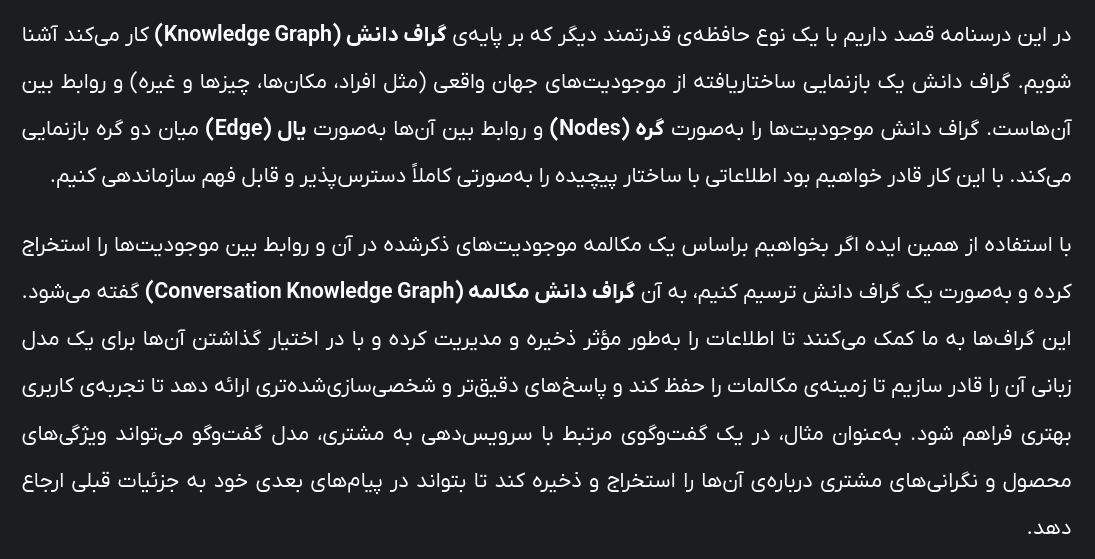

In [93]:
from langchain.memory import ConversationKGMemory

memory = ConversationKGMemory(llm=chat_model_for_history)

In [94]:
memory.save_context(
    {"input": "Diba and Parsa work at Quera"},
    {"output": "Oh, cool! What do they do there?"}
)

In [95]:
memory.kg.get_triples()

[('Diba', 'Quera', 'works at'), ('Parsa', 'Quera', 'works at')]

In [96]:
memory.save_context(
    {"input": "They are data scientists"},
    {"output": "That's awesome! I'm made of data too!"}
)

In [97]:
memory.kg.get_triples()

[('Diba', 'Quera', 'works at'),
 ('Diba', 'data scientist', 'is'),
 ('Parsa', 'Quera', 'works at'),
 ('Parsa', 'data scientist', 'is')]

In [98]:
memory.get_current_entities("What programming languages do Parsa use most?")

['Parsa']

In [99]:
memory.get_knowledge_triplets({"input":"Parsa mostly codes in Python"})

[KnowledgeTriple(subject='Parsa', predicate='mostly codes in', object_='Python')]